### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import glob
import time
import pandas as pd
# from xml.dom import minidom


import os
import matplotlib.pyplot as plt
import keras

import cv2

In [ ]:
df=pd.read_csv('XSS_dataset.csv', encoding='utf-8-sig')

In [ ]:
df.head()

,Unnamed: 0,Sentence,Label
0,0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,2,"\t </span> <span class=""reference-text"">Steeri...",0
3,3,"\t </span> <span class=""reference-text""><cite ...",0
4,4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [ ]:
df=df[df.columns[-2:]]  # Only get sentence and labels

In [ ]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [ ]:
# Get Sentences data from data frame
sentences=df['Sentence'].values
sentences[1]

'<tt onmouseover="alert(1)">test</tt>'

In [ ]:
print(len(sentences))

13686


In [ ]:
# Convert to ASCII

def convert_to_ascii(sentence):
    sentence_ascii=[]

    for i in sentence:
        
        
        """Some characters have values very big e.d 8221 adn some are chinese letters
        I am removing letters having values greater than 8222 and for rest greater 
        than 128 and smaller than 8222 assigning them values so they can easily be normalized"""
       
        if(ord(i)<8222):      # ” has ASCII of 8221
            
            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(134)
            
            
            if(ord(i)==8221): # ”  :  8221
                sentence_ascii.append(129)
                
            if(ord(i)==8220): # “  :  8220
                sentence_ascii.append(130)
                
                
            if(ord(i)==8216): # ‘  :  8216
                sentence_ascii.append(131)
                
            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(132)
            
            if(ord(i)==8211): # –  :  8211
                sentence_ascii.append(133)
                
                
            """
            If values less than 128 store them else discard them
            """
            if (ord(i)<=128):
                    sentence_ascii.append(ord(i))
    
            else:
                    pass
            

    zer=np.zeros((10000))

    for i in range(len(sentence_ascii)):
        zer[i]=sentence_ascii[i]

    zer.shape=(100, 100)


#     plt.plot(image)
#     plt.show()
    return zer


In [ ]:


# send each sentence to be converted to ASCII


arr=np.zeros((len(sentences),100,100))

for i in range(len(sentences)):
    
    image=convert_to_ascii(sentences[i])

    x=np.asarray(image,dtype='float')
    image =  cv2.resize(x, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    image/=128

    
#     if i==1:
#         plt.plot(image)
#         plt.show()    
    arr[i]=image



In [ ]:
print("Input data shape : ", arr.shape)

Input data shape :  (13686, 100, 100)


In [ ]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 100, 100, 1)

In [ ]:
data.shape

(13686, 100, 100, 1)

In [ ]:
y=df['Label'].values

In [ ]:
# Split into train/test data
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data,y, test_size=0.2, random_state=42)

In [ ]:
# import libraries for Making Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization

In [ ]:
# A basic CNN Model
# Number of layers = 11
# Number of Convolutional layer: 3

model=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64,(3,3), activation=tf.nn.relu, input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 10, 256)     

In [ ]:
# Stop when validation accuracy > 97

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.97):
            print(" \n Reached 97% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [ ]:
batch_size = 128
num_epoch = 10
#model training
model_log = model.fit(trainX, trainY,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=( testX,  testY)
  #callbacks=[callbacks]
                     )

Epoch 1/10
86/86 [==============================] - 486s 6s/step - loss: 0.4468 - accuracy: 0.7838 - val_loss: 0.3453 - val_accuracy: 0.8364
Epoch 2/10
86/86 [==============================] - 481s 6s/step - loss: 0.1743 - accuracy: 0.9399 - val_loss: 0.0854 - val_accuracy: 0.9733
Epoch 3/10
86/86 [==============================] - 476s 6s/step - loss: 0.0712 - accuracy: 0.9789 - val_loss: 0.1136 - val_accuracy: 0.9587
Epoch 4/10
86/86 [==============================] - 474s 6s/step - loss: 0.0547 - accuracy: 0.9845 - val_loss: 0.0575 - val_accuracy: 0.9843
Epoch 5/10
86/86 [==============================] - 478s 6s/step - loss: 0.0461 - accuracy: 0.9863 - val_loss: 0.0566 - val_accuracy: 0.9799
Epoch 6/10
86/86 [==============================] - 473s 6s/step - loss: 0.0387 - accuracy: 0.9890 - val_loss: 0.0489 - val_accuracy: 0.9879
Epoch 7/10
86/86 [==============================] - 473s 6s/step - loss: 0.0337 - accuracy: 0.9896 - val_loss: 0.0397 - val_accuracy: 0.9854
Epoch 8/10
86

In [ ]:
# predict for test set
pred=model.predict(testX)

86/86 [==============================] - 29s 340ms/step


In [ ]:
# Threshold values predicted
for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0

In [ ]:
# Count True predicted and wrong predicted
true=0
false=0
for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1
        
print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2709
false prediction ::  29


In [ ]:
# Number of attack and benign data in test set
attack=0
benign=0
for i in range(len(testY)):
    if testY[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  1478
 Benign data in test set ::  1260


### Confusion Matrix

In [ ]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy
def accuracy_function(tp,tn,fp,fn):
    
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    
    return accuracy

In [ ]:
# Takes True Positive and false positive
# Returns Precision
def precision_function(tp,fp):
    
    precision = tp / (tp+fp)
    
    return precision

In [ ]:
#Takes True Positive and false negative
# Returns Recall
def recall_function(tp,fn):
    
    recall=tp / (tp+fn)
    
    return recall

In [ ]:
#Takes true values and predicted
# Returns Accuracy, precision and recall
def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
            
    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)
    
    return (accuracy,
            precision,
           recall)

In [ ]:
accuracy,precision,recall=confusion_matrix(testY,pred)

In [ ]:
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

 Accuracy : 0.9894083272461651 
 Precision : 0.9872225958305313 
 Recall : 0.993234100135318


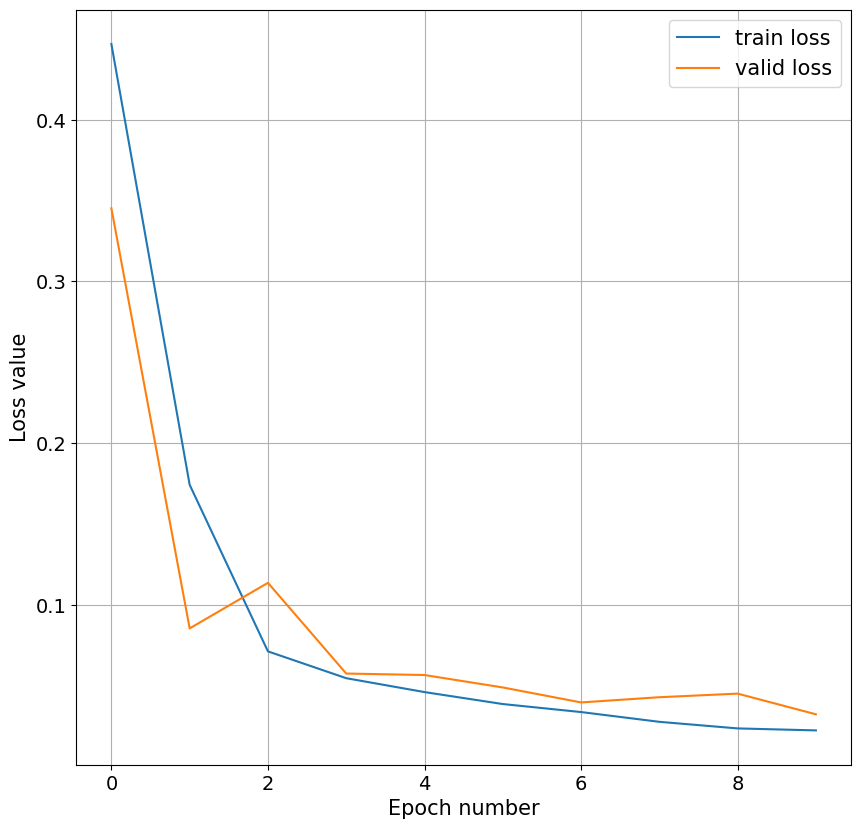

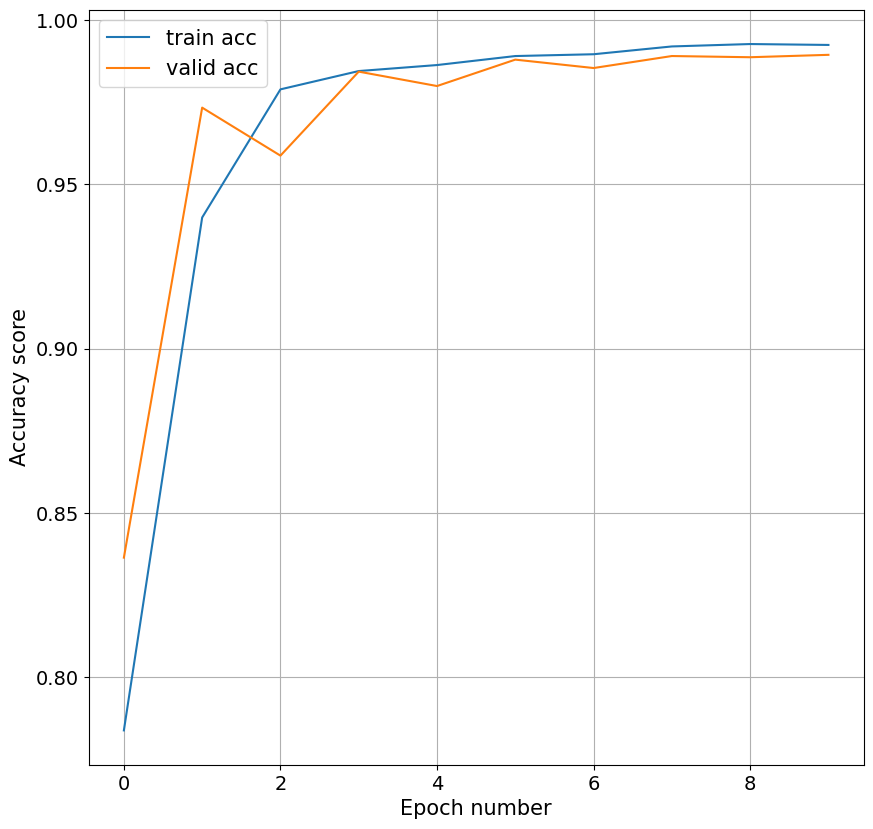

In [ ]:
def plot_history(history, param="loss"):
    plt.figure(figsize=(10, 10), dpi=100)
    if param == "loss":
        plt.plot(history.history["loss"], label="train loss")
        plt.plot(history.history["val_loss"], label="valid loss")
        plt.ylabel("Loss value", fontsize=15)
    elif param == "accuracy":
        plt.plot(history.history["accuracy"], label="train acc")
        plt.plot(history.history["val_accuracy"], label="valid acc")
        plt.ylabel("Accuracy score", fontsize=15)
    plt.xticks(fontsize=14)
    plt.xlabel("Epoch number", fontsize=15)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

# Visualize train and valid loss 
plot_history(model_log, "loss")

# Visualize train and valid accyracy 
plot_history(model_log, "accuracy")
